In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/glove840b300dtxt/glove.840B.300d.txt
/kaggle/input/tripadvisor-reviews-2023/New_Delhi_reviews.csv


In [2]:
# imported libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import os, re, csv, math, codecs
import string
import nltk 
from sklearn import metrics
from tqdm import tqdm

from tensorflow.keras import datasets, layers, models, optimizers, activations
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential, Model, load_model, save_model
from tensorflow.keras.layers import Dense, Bidirectional, LSTM, Dropout, BatchNormalization,Input,concatenate,GlobalAveragePooling1D,GlobalMaxPool1D, Activation, GRU,Conv1D
from tensorflow.keras.layers import Embedding
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.optimizers import RMSprop

from sklearn.model_selection import cross_val_score, cross_val_predict
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import KFold
from sklearn.utils import resample
from nltk.corpus import wordnet as wn
from nltk.stem import WordNetLemmatizer

# Performance metric
from sklearn.metrics import f1_score , hamming_loss, recall_score, precision_score, accuracy_score, make_scorer, classification_report
import pickle

/opt/conda/lib/python3.10/site-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.16.5 and <1.23.0 is required for this version of SciPy (detected version 1.24.3
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [3]:
df = pd.read_csv('/kaggle/input/tripadvisor-reviews-2023/New_Delhi_reviews.csv')
df = df.drop_duplicates()
df = df.reset_index(drop = True)
df.head()

,rating_review,review_full
0,5,"Totally in love with the Auro of the place, re..."
1,5,I went this bar 8 days regularly with my husba...
2,5,We were few friends and was a birthday celebra...
3,5,Fatjar Cafe and Market is the perfect place fo...
4,5,"Hey Guys, if you are craving for pizza and sea..."


<Axes: title={'center': 'target dataset'}, xlabel='rating_review'>

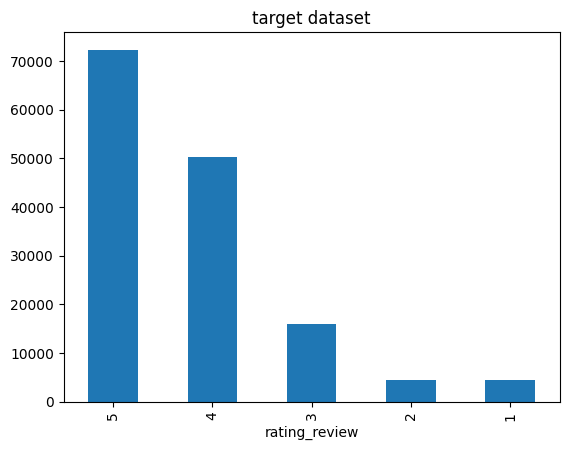

In [4]:
target = df['rating_review'].value_counts()
target.plot(kind = 'bar', title = 'target dataset')

In [5]:
# Resample the classes to match the number of instances in the "Lowest" class
df_label_lowest = df[df['rating_review'] == 1]
df_label_high = df[df['rating_review'] == 2]
df_label_highest = df[df['rating_review'] == 3]
df_label_medium = df[df['rating_review'] == 4]
df_label_low = df[df['rating_review'] == 5]

df_label_high_resampled = resample(df_label_high,
                                   replace=True,
                                   n_samples=df_label_lowest.shape[0],
                                   random_state=42)

df_label_highest_resampled = resample(df_label_highest,
                                      replace=True,
                                      n_samples=df_label_lowest.shape[0],
                                      random_state=42)

df_label_medium_resampled = resample(df_label_medium,
                                     replace=True,
                                     n_samples=df_label_lowest.shape[0],
                                     random_state=42)

df_label_low_resampled = resample(df_label_low,
                                  replace=True,
                                  n_samples=df_label_lowest.shape[0],
                                  random_state=42)

# Combine the resampled instances of all classes
df_balanced = pd.concat([df_label_lowest, df_label_high_resampled, df_label_highest_resampled, df_label_medium_resampled, df_label_low_resampled])

# Shuffle the balanced data
df_balanced = df_balanced.sample(frac=1, random_state=42).reset_index(drop=True)

# Check the class distribution
df_balanced['rating_review'].value_counts()

rating_review
1    4449
4    4449
5    4449
3    4449
2    4449
Name: count, dtype: int64

In [6]:
def preprocessing(text):
    text = text.lower()
    text = re.sub('\n', '', text)
    text = re.sub("\W"," ",text) 
    text = re.sub('https?://\S+|www\.\S+', '', text)
    text = re.sub('<.*?>+', '', text)
    text = re.sub('', '', text)
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text)
    text = re.sub('\w*\d\w*', '', text)    
    return text

df_balanced['review_full'] = df_balanced['review_full'].astype(str).apply(preprocessing)

In [7]:
def rem_numbers(data):
    return re.sub('[0-9]+','',data)

df_balanced['review_full'] = df_balanced['review_full'].astype(str).apply(rem_numbers)

In [8]:
text = df_balanced['review_full'].values
label = df_balanced['rating_review'].values
label = label - 1


In [9]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(text)
X = tokenizer.texts_to_sequences(text)
X = pad_sequences(X, padding = 'post', maxlen = 500)
y = to_categorical(label, num_classes = 5)


In [10]:
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2)
Xval, Xtest, yval, ytest = train_test_split(Xtest, ytest, test_size=0.4)

print(Xtrain.shape, ytrain.shape)
print(Xtest.shape, ytest.shape)
print(Xval.shape, yval.shape)

(17796, 500) (17796, 5)
(1780, 500) (1780, 5)
(2669, 500) (2669, 5)


In [11]:
embeddings_index = {}
f = codecs.open('/kaggle/input/glove840b300dtxt/glove.840B.300d.txt', encoding='utf-8')

In [12]:
for line in tqdm(f):
    values = line.rstrip().rsplit(' ')
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

2196019it [05:30, 6648.43it/s]


In [13]:
vocab_size = len(tokenizer.word_index) + 1
embedding_matrix = np.zeros((vocab_size, 300))

In [14]:
vocab_size = len(tokenizer.word_index) + 1
for word, i in tokenizer.word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector
        
embedding_matrix.shape

(31752, 300)

In [15]:
model = Sequential()
model.add(Embedding(input_dim = vocab_size, output_dim = 300, weights = [embedding_matrix], input_length = 500))
model.add(GRU(300, return_sequences = True))
model.add(GlobalMaxPool1D())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(5, activation='sigmoid'))


opt = RMSprop(learning_rate=0.001)
model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 300)          9525600   
                                                                 
 gru (GRU)                   (None, 500, 300)          541800    
                                                                 
 global_max_pooling1d (Glob  (None, 300)               0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 128)               38528     
                                                                 
 dropout (Dropout)           (None, 128)               0         
                                                                 
 dense_1 (Dense)             (None, 5)                 645       
                                                        

In [16]:
# creating checkpoint
checkpoint = ModelCheckpoint(
    'predictreview-GRU+Glove-v1.h5',
    monitor='val_loss',
    save_best_only=True
)

early_stop = EarlyStopping(monitor = 'val_accuracy', patience = 5)

In [17]:
class CustomCallback(Callback):
    def on_epoch_end(self, epoch, logs=None):
        if logs.get('accuracy') > 0.80 and logs.get('val_accuracy') > 0.80:
            self.model.stop_training = True
            print("\nThe accuracy of the training set and validation set has reached > 0.80!")
        else:
            print(f"\nCurrent accuracy - Training: {logs.get('accuracy')}, Validation: {logs.get('val_accuracy')}")

# Create an instance of the custom callback
custom_callback = CustomCallback()

In [18]:
# Training model
history = model.fit(Xtrain, ytrain,
                    batch_size = 64, epochs = 10,
                    validation_data = (Xval, yval), 
                    verbose = 1,
                    callbacks=[checkpoint, early_stop, custom_callback])

Epoch 1/10
279/279 [==============================] - ETA: 0s - loss: 1.2110 - accuracy: 0.4499
Current accuracy - Training: 0.4499325752258301, Validation: 0.457849383354187
279/279 [==============================] - 52s 165ms/step - loss: 1.2110 - accuracy: 0.4499 - val_loss: 1.2220 - val_accuracy: 0.4578
Epoch 2/10


/opt/conda/lib/python3.10/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


279/279 [==============================] - ETA: 0s - loss: 1.0017 - accuracy: 0.5505
Current accuracy - Training: 0.5505169630050659, Validation: 0.5271637439727783
279/279 [==============================] - 32s 116ms/step - loss: 1.0017 - accuracy: 0.5505 - val_loss: 1.0385 - val_accuracy: 0.5272
Epoch 3/10
279/279 [==============================] - ETA: 0s - loss: 0.9207 - accuracy: 0.5946
Current accuracy - Training: 0.5946280360221863, Validation: 0.532409131526947
279/279 [==============================] - 27s 98ms/step - loss: 0.9207 - accuracy: 0.5946 - val_loss: 1.0207 - val_accuracy: 0.5324
Epoch 4/10
279/279 [==============================] - ETA: 0s - loss: 0.8629 - accuracy: 0.6282
Current accuracy - Training: 0.6281748414039612, Validation: 0.5642562508583069
279/279 [==============================] - 23s 82ms/step - loss: 0.8629 - accuracy: 0.6282 - val_loss: 1.0049 - val_accuracy: 0.5643
Epoch 5/10
279/279 [==============================] - ETA: 0s - loss: 0.7954 - accur

In [19]:
loaded_model = load_model('predictreview-GRU+Glove-v1.h5')

In [21]:
y_pred = loaded_model.predict(Xtest)
pred_class = np.where(y_pred > 0.5, 1, 0)
print(classification_report(ytest, pred_class))

56/56 [==============================] - 1s 15ms/step
              precision    recall  f1-score   support

           0       0.54      0.88      0.67       385
           1       0.40      0.80      0.54       323
           2       0.43      0.74      0.54       357
           3       0.41      0.84      0.55       369
           4       0.58      0.85      0.69       346

   micro avg       0.46      0.82      0.59      1780
   macro avg       0.47      0.82      0.60      1780
weighted avg       0.47      0.82      0.60      1780
 samples avg       0.47      0.82      0.58      1780



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
